# CS345 Final Project Report

> Colin Shoning and Ian Kilty

## Introduction

### Dataset

The dataset used for this project is from a posting from [kaggle.com](https://kaggle.com) called [Predicting Credit Card Customer Segmentation](https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data) which sources an upload to [zendoo.org](https://zenodo.org) by a user named *zhyli* under the *Creative Commons Attribution 4.0 International* license. Here is the APA citation:

*zhyli. (2020). Prediction of Churning Credit Card Customers [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4322342*

This dataset contains many features that are both personal and financial, our usecase is to use personal features to make finanical classifications. Here are the personal features that are important to for our experiments, their data type and what they mean.

- `Attrition_Flag`: *boolean* - (`'Existing Customer'`/`'Attrited Customer'`) A boolean value representing if an entry is currently a customer or used to be a customer in the past.
- `Customer_Age`: *integer* - The age of the customer in years.
- `Gender`: *boolean* - (`M`/`F`) The gender of the customer.
- `Dependant_Count`: *integer* - The number of dependants that the customer has (Ex. child, partner, elderly parent).
- `Education_Level`: *categorical* - The highest education level that the customer has achieved which can include `'Uneducated'`, `'High School'`, `'College'`, `'Graduate'` or `'Unknown'`. 
- `Marital_Status`: *categorical* - The marital status of the customer which can include `'Single'`, `'Married'` or `'Unknown'` which is the reason this feature is not boolean.
- `Income_Category`: *categorical* - The range of income that the customer falls into based upon their annual income which ranges from `'Less than $40k'`, `'$40k - $60k'`, `'$60k - $80k'`, `'$80k - $120k'`, or `'Unknown'`.
- `Total_Relationship_Count`: *integer* - The number of relationships that the customer has with the credit card provider (Ex. Savings account, Checking account, Mortgage, Credit card accounts). 

Here is the financial feature that we are trying to make classifications about.

- `Credit_Limit`: *integer* - The total amount of money a customer is allowed to borrow on a credit card.

Because this features is an integer, we transform it into categorical data which is explained in the [Creating Variable Classifications](#Creating-Variable-Classifications) section of this notebook.

These personal features are important to us because our hypothesis is that there is a correlation between strictly personal data and strictly financial data. In other words, the credit limit of an individual **is not independant of every personal feature**. 

The dataset contains 10,127 customer records which provides a large enough sample to find patterns between demographic variables and financial variables. The dataset is pretty balanced across many of the categorical features but has a skew in variables such as income category and education level, which is only true in the read world and is reflected accuratly in the data gathered. The `Credit_Limit` variable has a skewed distribution, with a small number of people receiving very high credit limits. Because the dataset contains personal financial information, it raises some ethical questions about the potential bias in our models. For example, reliance on marital status, gender, or education level in real world models may introduce or reinforce discriminatory outcomes. Our project does not attempt to build a production grade credit model but instead evaluates correlations for academic and exploratory purposes.

## Data Loading and Formatting

Before we do anything, we need to load the credit card customer data properly. The `load_credit_card_customer_data` checks to see if the data file `BankChurners.csv` has already been downloaded and if not, it downloads it from `zenodo.org`. Initially we had this function return an `X, y` but it returns a `pandas` dataframe. This is because it's easier to index a `pandas` with the columns that we want to select, this functionality is present in `select_features`. We then select personal features that we want to use as information to predict a financial feature.

In [20]:
import os
import requests
import pandas as pd
import numpy as np

def load_credit_card_customer_data(X_features, y_label):
    filename = "BankChurners.csv"
    if not os.path.exists(filename):
        url = "https://zenodo.org/records/4322342/files/BankChurners.csv?download=1"
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)

    data = pd.read_csv(filename)
    X = data[X_features].values
    y = data[y_label].values
    return data, X, y

# dict used later on for cleaner indexing
personal_features = {
    'Attrition_Flag': 0,
    'Customer_Age': 1,
    'Gender': 2,
    'Dependent_count': 3,
    'Education_Level': 4,
    'Marital_Status': 5,
    'Income_Category': 6,
    'Total_Relationship_Count': 7
}

labels_column = 'Credit_Limit'
personal_features_headers = list(personal_features.keys())

data, X, y = load_credit_card_customer_data(personal_features_headers, labels_column)
X.shape, y.shape

((10127, 8), (10127,))

Here we can see that we have the `8` personal features and `1` label column. Also there is `10127` rows in this dataset which is pretty big. However, we can see that some of the columns contain categorical data. For example, the `'Attrition_Flag'` will contain either `'Existing Customer'` or `'Attrited Customer'` and the `'Gender'` column will only include `'M'` or `'F'` and so on with `'Education_Level'`, `'Marital_Status'` and `'Income_Category'`.

In [21]:
pd.DataFrame(X[:5, :], columns=personal_features)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Total_Relationship_Count
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,5
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,6
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,4
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,3
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,5


To fix this we need to transform this categorical data into numerical data.

### Transforming Categorical Data to Numerical Data

Classifiers like `SVM` can only interpret numerical data and not strings like `"Existing Customer"`. So we need to |convert these categorical features to binary categorical data using `OneHotEncoder`. This will create $n$ columns for $n$ different categories in the categorical column and label the entries with either $1$ or $0$ depending on if the entry is in that category. The reason that we don't just assign each category an integer is because we don't want there to be an *order* associated with a column and boolean columns achieve this by only assigning `1` or `0`.

In [22]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(col):
    encoder = OneHotEncoder(sparse_output=False) # sparse_output=False returns a regular numpy array which is needed for hstack
    arr = encoder.fit_transform(col.reshape(-1, 1)) # reshape for hstack
    headers = encoder.categories_[0].tolist() # get the respective categories that have been created
    return headers, arr

boolean_cols = ["Attrition_Flag", "Gender"]
integer_cols  = ["Customer_Age", "Dependent_count", "Total_Relationship_Count"]
categorical_cols = ["Education_Level", "Marital_Status", "Income_Category"]

X_numerical_parts = []
header_parts = []

for col_name in boolean_cols:
    idx = personal_features[col_name]
    col = X[:, idx]
    first_value = col[0] # The first entry's value is going to be represented by 1
    binary_col = np.where(col == first_value, 1, 0)
    X_numerical_parts.append(binary_col.reshape(-1, 1)) # reshape for hstack
    header_parts.append(f"{first_value}=1")

for col_name in integer_cols:
    idx = personal_features[col_name]
    col = X[:, idx].reshape(-1, 1) # reshape for hstack
    X_numerical_parts.append(col)
    header_parts.append(col_name)

for col_name in categorical_cols:
    idx = personal_features[col_name]
    col = X[:, idx]
    names, arr = one_hot_encode(col)
    X_numerical_parts.append(arr)
    header_parts.extend(names)

X_numerical = np.hstack(X_numerical_parts)

# dict for cleaner indexing later on
headers = { header: i for i, header in enumerate(header_parts) }

pd.DataFrame(X_numerical[:5, :], columns=header_parts)

,Existing Customer=1,M=1,Customer_Age,Dependent_count,Total_Relationship_Count,College,Doctorate,Graduate,High School,Post-Graduate,...,Divorced,Married,Single,Unknown,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,1,1,45,3,5,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,49,5,6,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,51,3,4,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0,40,4,3,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,40,3,5,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now we have completely numerical data, we can see that each category has its own binary column. We also have increased the number of columns from `8` to `22` because each category gets its own column.

In [23]:
X_numerical.shape

(10127, 22)

## Creating Variable Classifications

The last data formatting step we need to perform is the categorizaion of the `'Credit_Limit'`. For a binary classification, we will classify a customer based on if their credit limit is higher than the median or lower than the median. 

Later on, we will create more categories in order to compare the accuracy of a model based upon the number of different classifications it can make **on the same data**. We can take variable $g$ which represents the number of different classifications. When $g = 2$ we are classifying if a customer has a credit limit higher than the median, or a credit limit lower than the median. When $g = 3$ we are classifying if a customer is in the bottom 33rd percentile, in the middle 33rd percentile, or in the top 33rd percentile in terms of credit limit. This is part of our experimentation as this is an idea we had in order to measure the accuracy of models based the number of classification they could make **on the same data**.

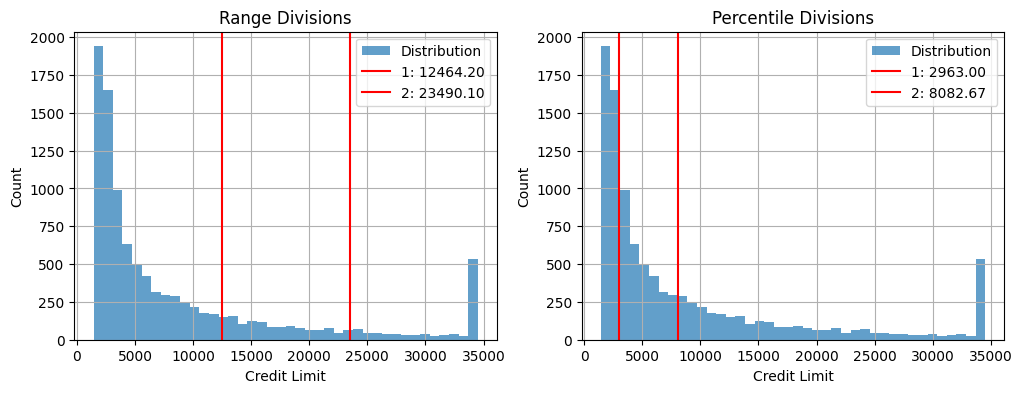

In [24]:
import matplotlib.pyplot as plt

def plot_divisions(ax, y, divisions, title=""):
    ax.hist(y, bins=40, alpha=0.7, label="Distribution")

    for i, division in enumerate(divisions):
        ax.axvline(division, color='red', label=f"{i+1}: {division:.2f}")

    ax.set_title(title)
    ax.set_xlabel("Credit Limit")
    ax.set_ylabel("Count")
    ax.grid(True)
    ax.legend()

def make_division(y, divisions):
    y = np.array(y)
    divisions = np.array(divisions)
    labels = np.zeros(len(y), dtype=int)
    
    for i, d in enumerate(divisions):
        labels[y > d] = i + 1
    return labels

def divide_percentile(g, y):
    chunk_size = 100 / g
    divisions = []
    for i in range(1, g): # start at 1 because we don't want to divide at the 0th percentile
        percentile = np.percentile(y, chunk_size * i)
        divisions.append(percentile)
    return divisions

def divide_range(g, y):
    y_min = min(y)
    y_max = max(y)
    step = (y_max - y_min) / g

    divisions = []
    for i in range(1, g): # start at 1 because we don't want to divide at 0
        divisions.append(y_min + i * step)

    return divisions

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
divisions_range = divide_range(3, y)
plot_divisions(axes[0], y, divisions_range, title="Range Divisions")

divisions_percentile = divide_percentile(3, y)
plot_divisions(axes[1], y, divisions_percentile, title="Percentile Divisions")
plt.show()

These two histograms show the quantity of entries based upon a range of their credit limit, shown with the blue distrobution. They differ in the divisions that they make which will be used to classify the entries. The "*Range Divisions*" graph divides the entries based upon the range of the credit limit itself, we take the credit limit range and divide it into $g$ equal chunks such that the range in each chunk is equal. In the "*Percentile Divisions*" we make divisions based upon **the quantity of entries**, this means that there is an equal number of entries in each chunk. 

These graphs help visualize the divisions. The "*Range Divisions*" graph has equal thirds on the credit limit axis, and the "*Percentile Divisions*" graph has smaller divisions where there is a larger quantity of entries. The question that we are going to discuss later on is "*Does some model perform better on data labeled with an equal **amount of entries** in each classification, or does it perform better on data labeled with an equal **range of labels**?*" (`divide_percentile` or `divide_range`).

For now we are going to use the binary classification using `divide_percentile(2, y)` in order to classify entries if they are higher or lower than the median, but later on we will discuss the performance of models based upon which method we are using to label the data.

In [25]:
y_median = np.median(y)
print(f"y median: {y_median}")

# binary classification, half above the median, half below the median
divisions = divide_percentile(2, y)
y_median = make_division(y, divisions)

pd.DataFrame([y[:5], y_median[:5]], index=["y", "y_median"])

y median: 4549.0


,0,1,2,3,4
y,12691.0,8256.0,3418.0,3313.0,4716.0
y_median,1.0,1.0,0.0,0.0,1.0


## Standardized vs Unstandardized Data

Our data has many columns that are either `1` or `0` because they were either *boolean* or *categorical*. The *integer* columns (`'Customer_Age'`, `'Dependent_count'`, and `'Total_Relationship_Count'`) are going unfairly outweigh all of the boolean columns because they all contain values larger than `1`. For example the `'Gender'` columns is going to have either a `1` or a `0` and the `'Customer_Age'` column ranges from `26` to `73` which is going to unfairly outweigh the `'Gender'` column and all other *boolean* columns.

To fix this we need to standardize the data in a way that equally considers both *boolean* and *integer* columns. 

The formula that we are using to standardize the data is:

$$
z = \frac{x - \mu}{\sigma}
$$

Where $z$ is the z-score or the standardized value of an entry, $x$ is the original value of the entry, $\mu$ is the average across all entries, and $\sigma$ is the standard deviation across all entries. This function does two things to standardize the data, first is that it centers the mean of the entries at 0 with $x - \mu$ and second, it makes the variance of the data equal to $1$ with $\frac{1}{\sigma}$. This way all the standardized data is centered around 0 and has an equal variance. This ensures that we are considering each feature equally in the data and we don't have any features that are outweighing others based on scale alone.

In [26]:
def standardize_col(col):
    col_mean = np.mean(col)
    col_std = np.std(col)
    if col_std == 0:
        col_std = 1
    return (col - col_mean) / col_std

X_standardized = X_numerical.copy()

for col_name in integer_cols:
    idx = headers[col_name]
    X_standardized[:, idx] = standardize_col(X_standardized[:, idx])

pd.DataFrame(X_standardized[:5], columns=header_parts)

,Existing Customer=1,M=1,Customer_Age,Dependent_count,Total_Relationship_Count,College,Doctorate,Graduate,High School,Post-Graduate,...,Divorced,Married,Single,Unknown,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,1,1,-0.165406,0.503368,0.763943,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,0.33357,2.043199,1.407306,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,0.583058,0.503368,0.120579,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0,-0.789126,1.273283,-0.522785,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,-0.789126,0.503368,0.763943,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In order to accurately test if our standardization is actually improving the quality of data, we are going to gather accuracies of unstandardized data and standandardized data using KNN. We will then iterate over different values of the hyperparameter `k` in order to see what the highest accuracy each dataset can achieve **using the same model**. 

#### Cross Validation

In order to accurately test our classifier with different hyperparameters, we need to **cross validate** the results from our training data with testing data. This is important because we don't want to overfit to out training data and falsely report a high accuracy. To cross validate the results from KNN we are going to use sklearn's `StratifiedKFold`. `StratifiedKFold` repeatedly splits the data into training and testing datasets such that each fraction of the entries labeled one way is equally represented in both the training and test sets with the same fractions. This is important because we have an equal percentage of classification partitions in the training and test sets to the data set as a whole. This simulates a real world scenerio where we need to train the model on data collected and make classifications based on unseen data. 

The `n_splits` value is the number of splits that we are going to be making with this cross validator. For instance if `n_splits=5`, we are going to divide the data into 5 parts and use a different fifth as the test data every iteration. These splits also ensure that we are keeping the same fraction of classifications across each split. In our case, we are splitting the data by the media which means that 50% of the data is in each classification. So our training and testing data are also going to contain 50% of each classification. 

The `shuffle=True` means that we are shuffling the data which is important because there might be some skewness in the way that the data is input into our dataset. We don't know how this data was collected, so we are going to shuffle the data just to be safe.

We then use the cross validator provided by `StratifiedKFold` to cross validate the training of the model with the training data against the classifications made with the testing data. We input our sklearn style classifier (`KNeighborsClassifier`), our feature matrix (`X`), our labels (`y`) and lastly our cross validator (`StratifiedKFold`) which runs 5 times (because `n_split=5`) and gathers the accuracy of each run (because `scoring="accuracy"`). 

We then take the average of these accuracies and plot them along the different values of the hyperparameter `k`.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

def get_knn_cv_results(X, y, k_values):
    rows = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for k in k_values:
        classifier = KNeighborsClassifier(k)
        results = cross_validate(classifier, X, y, cv=cv, scoring="accuracy", return_train_score=True)
        # gathering training and testing data to see if we are overfitting to the data
        rows.append({
            "k": k,
            "train_mean": np.mean(results["train_score"]),
            "test_mean":  np.mean(results["test_score"]),
        })
    return pd.DataFrame(rows)

k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
knn_unstandardized_cv_results = get_knn_cv_results(X_numerical, y_median, k_values)
knn_standardized_cv_results = get_knn_cv_results(X_standardized, y_median, k_values)

unstandardized_accuracies = knn_unstandardized_cv_results['test_mean']
standardized_accuracies = knn_standardized_cv_results['test_mean']

plt.plot(k_values, unstandardized_accuracies, label="Unstandardized")
plt.plot(k_values, standardized_accuracies, label="Standardized")

plt.xscale('log', base=2)
plt.xlabel("Neighbors")
plt.ylabel("Mean Accuracy")
plt.title("Standardized vs Unstandardized")
plt.grid(True)
plt.legend()
plt.show()

We can then see that KNN performs better using the standardized data than the unstandardized data. The standardized data doesn't have the *integer* columns outweighing all the other *boolean* columns and can equally consider each feature for the classification. It's also interesting that the accuracy of the model using the standardized data peaks at `k=64` and the accuracy of the model using the unstandardized data peaks at `k=32`. 

Our hypothesis is that the *integer* columns in the unstandardized data have greater values on average than the *boolean* columns which leads to a skewed distance calculation when finding the nearest neighbors to an entry from the test set. When calculating the distance between two points, the unstandardized integer column is going to provide over inflated distance measurements because the majority of the data is contains *boolean* values.

For instance, suppose we are only considering the `'Gender'` and `'Customer_Age'` columns of two entries. Let's say entry one has `1, 34` and entry two has `0, 40` with the columns being `'Gender'` and `'Customer_Age'` respectively. These entries differ in `'Gender'` by `1` and differ in `'Customer_Age'` by `6` which means that when we measure the distance between these two points, they are going to seem farther apart because of the **type and range of data** in `'Customer_Age'` when we should actually be considering `'Gender'` and `'Customer_Age'`. This causes inaccuracies in our data which leads to a lower average accuracy for unstandardized data.

Standardized data performs better because we now have a more similar range of data to the *boolean* columns as our integer columns have been centered around 0 and have a variance of 1.

## Model Selection

It's time we research different classifiers in order to determine which algorithms can best capture the structure of our data, find patterns, and make predictions.

### Baseline Comparison

In order to accurately analyze the performance of every model, we need an accurate baseline to compare it to. Here we are using `sklearn`'s `DummyClassifier` which is going to pick the most frequent label for every entry. In our case, we are splitting the data by the median which means there is going to be an equal frequency for each label, in this case the `DummyClassifier(strategy="most_frequent")` is going to pick the first array value in it's array of labels, so the same label every time.

In [ ]:
from sklearn.dummy import DummyClassifier
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = DummyClassifier(strategy="most_frequent")

results = cross_validate(clf, X_standardized, y_median, cv=cv, scoring="accuracy")
baseline_accuracy = np.mean(results["test_score"])
print("Baseline accuracy:", baseline_accuracy)

An accuracy of `0.5` makes sense because each classification makes up `0.5` of our data, and if the `DummyClassifier` picks the same most frequent classification everytime, the accuracy is going to be `0.5`.

### Nature of the Dataset

Our data contains many *boolean* columns because either the column is *boolean* or because of one hot encoding categorical data. The data contained in non-*boolean* columns, are discrete integers and not continuous. We can see this clearly when we plot `'Dependent_count'` against `'Total_Relationship_Count'` which are two integer columns.

In [ ]:
dependant_count_col = X_standardized[:, headers["Dependent_count"]]
relationship_count_col = X_standardized[:, headers["Total_Relationship_Count"]]

plt.scatter(dependant_count_col, relationship_count_col, c=y_median, alpha=0.2)

plt.title("Dependent Count vs Total Relationship Count")
plt.xlabel("Dependent Count")
plt.ylabel("Total Relationship Count")
plt.grid(True)
plt.show()

Even though we standardized the data, there are still only a set amount of values that the `'Dependent_count'` and `'Total_Relationship_Count'` can be. This leads to a sort of lattice structure where every combination of integer points is covered, and all the unstandardized points are discrete integers, leading to the same standardized value for many entries.

This graph doesn't give us very much information, there are many points plotted on top of each other and it's hard to see any sort of pattern in the data. However, this partially explains how the `KNearestNeighbors` classifier is working on this data. When comparing these two features, the nearest neighbors of a point are going to be the points that **exactly overlap** in value to the point we are trying to classify. 

### Radius Neighbors Classifier

The radius neighbors classifier is similar to the k-nearest neighbors classifier but instead of taking the classification vote of a set number of neighbors, there is a radius that defines a circle around an entry in which all the points contained in that circle get a classification vote that decides the classification of the entry. If there is a tie in the votes between all the entries within the radius, a classification is chosen at random. The `radius` is a hyperparameter for this classifier.

#### Hypothesis

Our hypothesis is that the radius neighbors classifier will perform better than the k-nearest neighbors classifer because of the discrete nature of the data. For instance, in the graph above each combination of standardized values is going to contain a quantity of points with some combinations having more than others. When we use the k-nearest neighbors classifier, we are considering the same number of points across all combinations, and because some combinations have more points than others, some elections will contain votes from vastly different combinations and some will not. This difference in taking votes from vastly different combinations hurts overall accuracy of the k-nearest neighbors classifier because sometimes we are considering only points in the same combination and sometimes not.

For example, suppose that one combination has `55` points and another has `74` and we are using k-nearest neighbors with `k=64`. For the combination that contains `55` points, we are considering points **outside** of that combination in order to elect a classification for a new point, and for the combination that contains `74` points, we are only considering points **inside** of the same combination. This leads to **more noise** when trying to classify a new point that lands on the combination with `55` points.

To attempt to fix this addition of noise we will use the radius neighbors classifier to consider a set of points defined by **a radius rather than a quantity**. For example if we have a small radius in which we only consider points with the same or a very similar combination of features, then we are not introducing any new noise in needing to consider the next nearest point (which might be in a very different combination) as we did with k-nearest neighbors.

Of course there are many other features that we need to consider which provide their own set of combinations, so we will often consider a *small* number of *similar* combinations that are within our radius instead of just one combination within a very small radius, because it's rare that entries are going to have the exact same combination of discrete values.

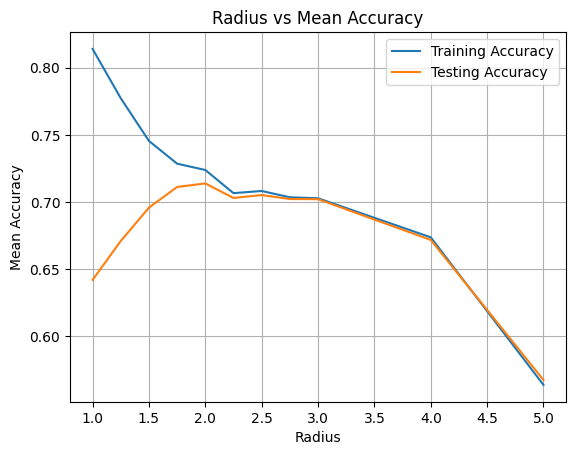

,radius,train_mean,test_mean
0,1.00,0.814062,0.641750
1,1.25,0.777279,0.670781
2,1.50,0.745433,0.695666
3,1.75,0.728449,0.711071
4,2.00,0.723758,0.713737
5,2.25,0.706478,0.702875
6,2.50,0.708082,0.705048
7,2.75,0.703392,0.702086
8,3.00,0.702651,0.701987
9,4.00,0.673521,0.671573


In [13]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import cross_validate

def get_radius_cv_results(X, y, radius_values):
    rows = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for radius in radius_values:
        # outlier_label=0 is for points that do not have any neighbors within the radius in which
        # we ignore them by labeling them as 0 in our prediction
        clf = RadiusNeighborsClassifier(radius=radius, outlier_label=0)
        results = cross_validate(clf, X, y, cv=cv, scoring="accuracy", return_train_score=True)
        # gathering training and testing data to see if we are overfitting to the data
        rows.append({
            "radius": radius,
            "train_mean": np.mean(results["train_score"]),
            "test_mean":  np.mean(results["test_score"]),
        })
    return pd.DataFrame(rows)


radius_values = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 4, 5]
cv_results = get_radius_cv_results(X_standardized, y_median, radius_values)
train_accuracies = cv_results["train_mean"]
test_accuracies = cv_results["test_mean"]
plt.plot(radius_values, train_accuracies, label="Training Accuracy")
plt.plot(radius_values, test_accuracies, label="Testing Accuracy")

plt.xlabel("Radius")
plt.ylabel("Mean Accuracy")
plt.title("Radius vs Mean Accuracy")
plt.legend()
plt.grid(True)
plt.show()

cv_results

We can see in the graph above the we are overfitting to the training data when the radius is `1`, this is evident because we have a suprisingly high accuracy for the `train_mean` and a lower accuracy for the `test_mean`. The best performing value for the radius turns out to be `2` because with this value for the radius, we achieve the highest testing accuracy at `0.7135`. Then there is a steep drop off in accuracy when we keep increasing the radius. 

#### Baseline analysis

As shown above, our baseline accuracy for the data we have formatted is `0.5` becase we are dividing the data into two equal groups. Our accuracy when we increase the radius to `5` is `0.56` which is pretty horrible because our baseline is `0.5`. When the radius is `5` we are only slightly better off using the radius neighbors classifier with a radius of `5` than always choosing the most frequent label, which is pretty bad. However, an accuracy of `0.7135` provides a significant improvement from an accuracy of `0.5` and we are much better off using the radius neighbors classifier with a radius of `2` than always choosing the most frequent label.

#### Compared to KNN

However, the accuracy of the radius nearest neighbors classifier does not outperform the k-nearest neighbors classifier. Here is the accuracy of the k-nearest neighbors classifier.

In [14]:
knn_standardized_cv_results["test_mean"].max()

np.float64(0.7130467868329007)

This means that we **fail to accept** our hypothesis which means there must be other factors that impact the observed accuracy of radius neighbors on the data. It's possible that our hypothesis was incorrect all together and the radius neighbors classifier and the k-nearest neighbors classifier both use very similar points in their elections. Without further investigation, it's hard to say exactly why this classifier does not outperform the k-nearest neighbors classifier. An accuracy of `0.72` could be the ceiling of the data, or there could be many other factors that all balance out both classifiers to a similar accuracy.

### Random Forest Classifier

The `RandomForestClassifier` is an ensemble classifier that uses many decision trees to produce a more stable and generalized model for prediction. Decisions trees can easily overfit to data, so the `RandomForestClassifier` uses many decision trees in conjunction with each other 

#### Hypothesis
There are many binary features in our dataset, and the features that are not binary are discrete. All these binary and discrete features create hard decision boundaries for decision trees by splitting data based on if a feature is a `1` or a `0` or some integer. This makes the `RandomForestClassifier` an intuitive choice for data with lots of boolean or discrete values. Our prediction is that the `RandomForestClassifier` will outperform both the radius neighbors classifier and the k-nearest neighbors classifier because of the hard decision boundaries that can be made inside of a decision tree. The ensemble aspect of the `RandomForestClassifier` also plays an important role to ensure that we are not only considering a single decision tree, but many trees in order to **make a prediction off an aggregate rather than a single tree**.

Because the random forest model is fast in training, it is computationally feasible to perform a grid search with `GridSearchCV`. We are going to search three hyperparameters. The first is `n_estimators` which is the number of trees that we are going to be using in our forest. Next is the `max_depth` which is the max depth of each tree in the forest. Then `min_samples_leaf` which is the minimum number of samples from the data set that are required for a node in the tree to be considered a leaf, or in other words, stop splitting.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier()

param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [5, 10, 20],
    "min_samples_leaf": [2, 4, 8]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(classifier, param_grid, cv=cv, scoring="accuracy")

Let's see how long this takes

In [16]:
%%time

grid.fit(X_standardized, y_median);

CPU times: total: 1min 1s
Wall time: 1min 1s


In [17]:
print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 300}
Best accuracy: 0.7275612591861359


An accuracy of `0.727` is only slightly better than the radius neighbors classifier and the k-nearest neighbors classifier which means that we **fail to accept** our hypothesis but we are performing much better than the baseline so the `RandomForestClassifier` is still finding meaningful patterns in the data. However, results from the hyperparameter grid search are interesting. With a `max_depth` of 5 and a `min_samples_leaf` of 2, it seems that the forest ensemble contains lots of trees that contain leaf nodes with either a high number of samples or a low number of samples. Because of this, it makes sense that `n_estimators` is `300` rather than `100` because there are more trees that can cover the smaller groups which makes up more of the dataset. Without further investigation, it's hard to know exactly why these parameters perform the best in the grid search.

#### Confusion Matrix

In order to further analyze the performance of the optimal parameters, we are going to create a confusion matrix which shows the amount of false positives and false negatives that our classifier made.

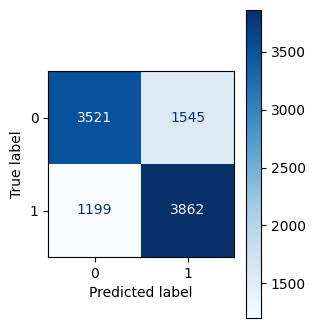

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import confusion_matrix

best_random_forest = grid.best_estimator_
y_pred = best_random_forest.predict(X_standardized)

matrix = confusion_matrix(y_median, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=sorted(set(y_median)))
fig, ax = plt.subplots(figsize=(3,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

Here the `0` label represents an entry under the median credit limit and a `1` represent an entry above the median credit limit.

If the question we are asking is, "*Is this customer above the median credit limit?*" we have `1542` entries classified as above the credit limit when they were actually below (false positive) and `1199` entries classified as below the median when they were actually above (false negative). Our prediction for why there are slightly more false positives than false negatives is that the `Credit_Limit` distribution is heavily right skewed and there are lots of entries that have around the same `Credit_Limit`. But it is also possible that this might just be some noise in the data and our `RandomForestClassifier` has a different number of false positives and false negatives for an extension of the data.

## Model Performance on Multiclassification Problems

So far we have used three classifiers that all result in a reasonably equal accuracy at around `0.72` by splitting the data into two equal parts. Now we will compare each of our classifiers on multiclassification problems by splitting by the percentile of the `Credit_Limit` using `divide_percentile` or splitting by the range of the `Credit_Limit` using `divide_range`. To know more about how each of these functions are splitting the data, refer to the [Creating Variable Classifications](#Creating-Variable-Classifications) section of this notebook.

In [47]:
def test_variable_classifications(X, y, classifiers, num_divisions, divide_func):
    rows = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for num_division in num_divisions:
        divisions = divide_func(num_division, y)
        y_divided = make_division(y, divisions)
        for classifier in classifiers:
            results = cross_validate(classifier, X, y_divided, cv=cv, scoring="accuracy", return_train_score=True)
            rows.append({
                "divisions": num_division,
                "classifier": classifier.__class__.__name__,
                "train_mean": np.mean(results["train_score"]),
                "test_mean":  np.mean(results["test_score"])
            })
    return rows

dummy_classifier = DummyClassifier(strategy="most_frequent")
radius_neighbors_classifier = RadiusNeighborsClassifier(2, outlier_label=0)
k_nearest_neighbors_classifier = KNeighborsClassifier(64)
random_forest_classifier = RandomForestClassifier(max_depth=5, min_samples_leaf=8, n_estimators=300)

classifiers = [
    dummy_classifier,
    radius_neighbors_classifier, 
    k_nearest_neighbors_classifier, 
    random_forest_classifier
]

num_divisions = [2, 3, 4, 5, 6]

results = test_variable_classifications(X_standardized, y, classifiers, num_divisions, divide_percentile)
pd.DataFrame(results)

,divisions,classifier,train_mean,test_mean
0,2,DummyClassifier,0.500247,0.500247
1,2,RadiusNeighborsClassifier,0.723857,0.713540
2,2,KNeighborsClassifier,0.721586,0.713442
3,2,RandomForestClassifier,0.728128,0.726672
4,3,DummyClassifier,0.333465,0.333465
5,3,RadiusNeighborsClassifier,0.545991,0.530365
6,3,KNeighborsClassifier,0.547966,0.526415
7,3,RandomForestClassifier,0.555446,0.542017
8,4,DummyClassifier,0.250321,0.250321
9,4,RadiusNeighborsClassifier,0.444529,0.423423


It's crucial to compare the performance of each classifier against the baseline (`DummyClassifier`) in order to know whether the model is actually learning meaningful patterns from the data or performing at the level of simply selecting the most frequent classification. For example, when we split the data into 6 different parts, our accuracy for all the models drops to around `0.30`, but compared to the baseline accuracy of `0.16` our classifiers still perform reasonably similar to the performance with 2 divisions. This means that our classifiers are still learning meaningful patterns in the data and can use those patterns to make predictions with a higher accuracy than the baseline.

However, we were suprised to see how similarly each of the models performed on each division. Each of the classifiers accuracies are around the same values for each division, we thought that there might be one classifier that performs better than others when there are more classifications but that is not the case with these three classifiers. 

Now we can test how each of our classifiers performs on data labeled by **dividing by the range** of credit limits rather than dividing by the percentile using `divide_range`.

In [48]:
results = test_variable_classifications(X_standardized, y, classifiers, num_divisions, divide_range)
pd.DataFrame(results)

,divisions,classifier,train_mean,test_mean
0,2,DummyClassifier,0.855337,0.855337
1,2,RadiusNeighborsClassifier,0.858226,0.856325
2,2,KNeighborsClassifier,0.857781,0.854942
3,2,RandomForestClassifier,0.855387,0.855337
4,3,DummyClassifier,0.779303,0.779303
5,3,RadiusNeighborsClassifier,0.781944,0.780192
6,3,KNeighborsClassifier,0.782068,0.779796
7,3,RandomForestClassifier,0.780142,0.780192
8,4,DummyClassifier,0.717883,0.717883
9,4,RadiusNeighborsClassifier,0.721709,0.719266


This is horrible. 

In most cases we barely outperform the baseline `DummyClassifier` and sometimes we don't outperform it at all. Even though our accuracy for 2 divisions has now increased to around `0.85`, this is most likely because 85% of the data is labeled one way which is why our `'most_frequent'` type `DummyClassifier` reaches an accuracy of `0.85`. **By changing how the data is labeled, our classifiers are no longer able to find any meaningful patterns in the data.**

It would be interesting to search again for the optimal hyperparameters for each of the classifiers and view the accuracy compared to the baseline.

# Conclusion